# Polygons

Joining geographic points with U.S. and County polygons.

In [1]:
# Libraries

%run utilities.py
%matplotlib inline

In [2]:
# Geography libraries
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt

from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from descartes import PolygonPatch
from shapely.geometry import Point

In [3]:
## Functions used
def plot_polygons(gdf_polygons):
    # create polygons
    patches = [PolygonPatch(geometry) for geometry in gdf[gdf['geometry'].notnull() == True]['geometry']]
    # group overlapping polygons
    pc = PatchCollection(patches, facecolor='#3399cc', linewidth=1, alpha=0.1)
    
    # create the map figure
    fig, ax = plt.subplots(figsize=(9.6, 5))
    ax.add_collection(pc)

    # ...then set the figure bounds to the polygons' bounds
    left, bottom, right, top = gdf.total_bounds
    ax.set_xlim((left,right))
    ax.set_ylim((bottom,top))
    plt.show()

---

In [4]:
# files
counties_f = name_file_path('attributes.json', external_maps_dir)

states_f = name_file_path('state.geo.json', external_maps_dir)

world_f = name_file_path('110m.json', external_maps_dir)

In [16]:
### Maps

# colors
land_color = '#DDDDDD'
water_color = '#D2F5FF'
coastline_color = '#333333'
border_color = '#999999'

# Dimensions
map_width_m = 5000 * 1000 #5000 km
map_height_m = 3500 * 1000 #3500 km

# Albers Conical Equal Area projection for USA
albers_usa = {
    'datum':'NAD83',
    'ellps':'GRS80',
    'proj':'aea', 
    'lat_1':33, 
    'lat_2':45, 
    'lon_0':-97, 
    'lat_0':39, 
    'x_0':map_width_m/2, 
    'y_0':map_height_m/2,
    'units':'m'
 }

---

*test basic mapping*

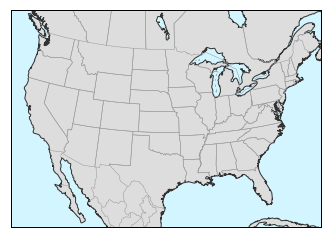

In [12]:
# matplotlib
m = Basemap(ellps=albers_usa['ellps'],
            projection=albers_usa['proj'],
            lat_1=albers_usa['lat_1'], 
            lat_2=albers_usa['lat_2'], 
            lon_0=albers_usa['lon_0'], 
            lat_0=albers_usa['lat_0'],
            width=map_width_m, 
            height=map_height_m,
            resolution='l', #l means low resolution boundaries
            area_thresh=10000) #coastline or lake with an area smaller than this km^2 will not be plotted

m.drawcoastlines(color=coastline_color)
m.drawcountries(color=border_color)
m.fillcontinents(color=land_color, lake_color=water_color)
m.drawstates(color=border_color)
m.drawmapboundary(fill_color=water_color)

In [76]:
# in line plotting
#print('{!r}'.format(type(gsrs.values[-1])))

---

**The actual data**

In [52]:
### Read in and prepare the files

states = gpd.read_file(states_f)
counties = gpd.read_file(counties_f)

In [53]:
# projection check
print ('States CRS: {}'.format(states.geometry.crs))
print ('U.S. Counties CRS: {}'.format(counties.geometry.crs))

States CRS: {'init': 'epsg:4326'}
U.S. Counties CRS: {'init': 'epsg:4326'}


In [54]:
# drop empties
states.dropna(subset=['geometry'], inplace=True)
counties.dropna(subset=['geometry'], inplace=True)

# nice! But they should be albers
states = states.to_crs(albers_usa)
counties = counties.to_crs(albers_usa)

In [55]:
print (states.columns.tolist())
print (counties.columns.tolist())

['ALAND10', 'AWATER10', 'DIVISION10', 'FUNCSTAT10', 'GEOID10', 'INTPTLAT10', 'INTPTLON10', 'LSAD10', 'MTFCC10', 'NAME10', 'REGION10', 'STATEFP10', 'STATENS10', 'STUSPS10', 'geometry']
['American_I', 'Asian', 'Black', 'Difference', 'Employed', 'FID_1', 'FIPS', 'Labor_Forc', 'Median_Hou', 'Multi_Race', 'Pacific_Is', 'Pct_BD_Or_', 'Pct_Dem', 'Pct_Gop', 'Pct_Less_T', 'Pct_Only_H', 'Pct_Point_', 'Pct_Some_C', 'Population', 'Total_Vote', 'Tweet_Rate', 'Tweets', 'Unemployed', 'Unemployme', 'Votes_Dem', 'Votes_Gop', 'White', 'geometry']


In [56]:
states[['GEOID10', 'NAME10', 'STATEFP10', 'STUSPS10']].head()

,GEOID10,NAME10,STATEFP10,STUSPS10
0,56,Wyoming,56,WY
1,42,Pennsylvania,42,PA
2,39,Ohio,39,OH
3,35,New Mexico,35,NM
4,24,Maryland,24,MD


In [57]:
counties[['FID_1', 'FIPS']].head()

,FID_1,FIPS
0,53073,53073
1,30105,30105
2,30029,30029
3,16021,16021
4,30071,30071


**Adding State name to counties.** Download the file from the internet, and load it into a dataframe.

In [70]:
census_cols = ['abbrv', 'STATE', 'STATEFP', 'COUNTYFP', 'COUNTYNAME']
dtypes = {'STATE': 'str', 'STATEFP':'str'}
county_names = pd.read_csv('https://www2.census.gov/geo/docs/reference/codes/files/national_county.txt',
                          names=census_cols,
                          dtype=dtypes)
county_names.head()

,abbrv,STATE,STATEFP,COUNTYFP,COUNTYNAME
0,AL,01,001,Autauga County,H1
1,AL,01,003,Baldwin County,H1
2,AL,01,005,Barbour County,H1
3,AL,01,007,Bibb County,H1
4,AL,01,009,Blount County,H1


In [71]:
counties.FIPS.head()

0    53073
1    30105
2    30029
3    16021
4    30071
Name: FIPS, dtype: int64

In [73]:
# set the type to str so we can match on the columns
#counties['FIPS'] = counties.FIPS.astype(str)

#county_names['FIPS'] = county_names[['STATE', 'STATEFP']].apply(lambda s, f: str(x) + str(f))

TypeError: ("<lambda>() missing 1 required positional argument: 'f'", 'occurred at index STATE')

In [74]:
# make a column to grab the name
#counties['GEOID10'] = counties['FIPS'].map(lambda x: int(str(x)[:2]))

In [75]:
# add the state name and abbreviation to the counties polygons.
#new_map = counties.join(states[['NAME10', 'GEOID10', 'STUSPS10']], on='GEOID10', how='left')

new_map.head(2)

,name,abbrv,American_I,Asian,Black,Difference,Employed,FIPS_ID,Labor_Forc,Median_Hou,...,Total_Vote,Tweet_Rate,Tweets,Unemployed,Unemployme,Votes_Dem,Votes_Gop,White,geometry,State_ID
0,NaN,NaN,6880,9371,2617,"19,155","96,808",53073,"102,918",55073,...,108223,0,9,"6,110",5.9,59402,40247,184733,"POLYGON ((754540.571149582 3090099.630101081, ...",53
1,Massachusetts,MA,741,60,37,"1,811","4,297",30105,"4,434",46698,...,3860,0,0,137,3.1,886,2697,6636,"POLYGON ((1826695.815992063 2894846.498266631,...",30


In [40]:
#### ASK BAILEY TO DEFINE ALL OF THESE VARIABLES
### YEARS, EVERYTHING
rnm = {
    'STUSPS10': 'abbrv',
    'NAME10': 'name',
    'FIPS': 'FIPS_ID'
    }
# remove
rmv = ['FID_1', 'STATEFP']

new_map.rename(columns=rnm, inplace=True)
#new_map.drop(rmv, inplace=True)

In [45]:
new_map = new_map[['name', 'abbrv', 'American_I', 'Asian', 'Black', 'Difference', 'Employed',
       'FIPS_ID', 'Labor_Forc', 'Median_Hou', 'Multi_Race', 'Pacific_Is',
       'Pct_BD_Or_', 'Pct_Dem', 'Pct_Gop', 'Pct_Less_T', 'Pct_Only_H',
       'Pct_Point_', 'Pct_Some_C', 'Population', 'Total_Vote', 'Tweet_Rate',
       'Tweets', 'Unemployed', 'Unemployme', 'Votes_Dem', 'Votes_Gop', 'White',
       'geometry', 'State_ID']]

In [ ]:
# filter out alaska and hawaii for the web map eventually

# remove any point data that lies within Alaska or Hawaii
alaska_polygon = states[states['NAME10']=='Alaska']['geometry'].iloc[0]
hawaii_polygon = states[states['NAME10']=='Hawaii']['geometry'].iloc[0]

# now use a mask to select all points *not* within either state's polygon
# states[(states.STUSPS10 == 'AK') | (states.STUSPS10 == 'HI')][['STUSPS10', '']]
continental = states[(states.STUSPS10 != 'AK') | (states.STUSPS10 != 'HI')]